In [2]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


# KS Testing

## Split the RMs into two populations

In [69]:
#master_hvcs[0]["RMs"]
master_hvcs[4]["HVC"]

Name,SkyCoord,RAJ2000,DEJ2000,VLSR,e_VLSR,VGSR,Vdev,FWHM,TbFit,NH,e_NH,Area,dx,dy,Flag,HI,WW91,Simbad,recno,Cat,Nearest RM
,"deg,deg",,,km / s,km / s,km / s,km / s,km / s,K,1 / cm2,1 / cm2,deg2,deg,deg,,,,,,,deg
str15,SkyCoord,str11,str9,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4,str19,str18,str6,int32,str4,float64
G133.5-75.6-294,"15.548161692114391,-13.005834286896315",01 02 11.56,-13 00 21,-294.1,1.8,-254.6,-261.6,26.8,0.42,2e+19,3e+18,1.3,4.2,1.4,H2,HVC 131.9-75.8-302,"EN,MS_MS",Simbad,427,GHVC,0.048293947366666666


In [28]:
import numpy as np

def split_RMs(RMs, centre, max_distance):
    mask = np.zeros(len(RMs), dtype=bool)
    for i in range(len(RMs)):
        rmi = RMs[i]
        mask[i] = rmi["ra_dec_obj"].separation(centre).value < max_distance

    RMs_inner = RMs[~mask]
    RMs_outer = RMs[mask]

    return RMs_inner, RMs_outer
        

inner, outer = split_RMs(master_hvcs[0]["RMs"], master_hvcs[0]["HVC"]["SkyCoord"], max(master_hvcs[0]["HVC"]["dx"], master_hvcs[0]["HVC"]["dy"]))

#print(len(master_hvcs[0]["RMs"]))
print(len(inner))
print(len(outer))

144
909


## Produce CDFs of distributions

In [50]:
import scipy.stats as stats

def make_cdfs(inner, outer):
    inner_data = np.sort(inner["B_virtual [int]"].data*1e6)
    inner_cdf = stats.norm.cdf(inner_data)

    outer_data = np.sort(outer["B_virtual [int]"].data*1e6)
    outer_cdf = stats.norm.cdf(outer_data)

    return inner_data, inner_cdf, outer_data, outer_cdf

inner_data, inner_cdf, outer_data, outer_cdf = make_cdfs(inner, outer)
#print(inner_cdf)
#print(np.sort(inner["B_virtual [int]"].data*1e6))

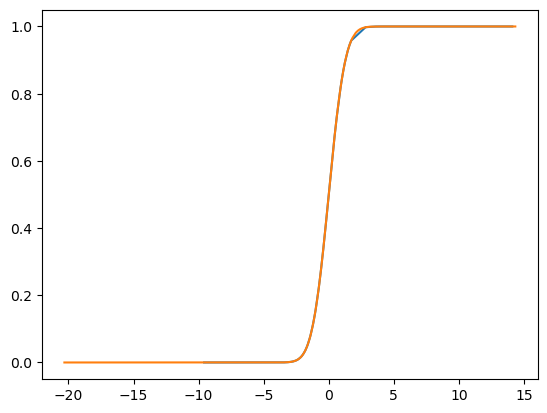

In [51]:
import matplotlib.pyplot as plt

plt.plot(inner_data, inner_cdf)
plt.plot(outer_data, outer_cdf)
plt.show()

## Perform Scipy KS test

Analysing HVC: G133.5-75.6-294


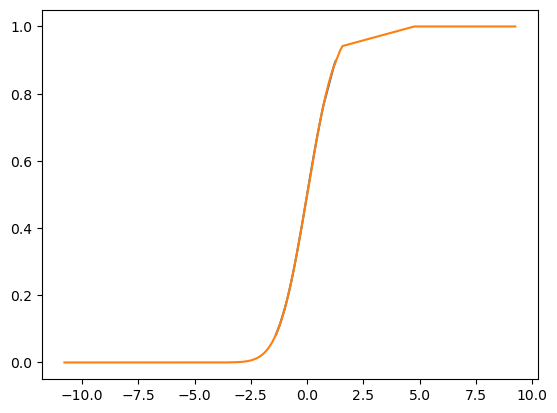

{'Name': 'G133.5-75.6-294',
 'Statistic': 0.46130268199233715,
 'p_value': 4.570648166268751e-08,
 'Statistic_x': -1.0081759072724916,
 'Statistic_sgn': -1,
 'Significant': True}

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.table import Table

def column_to_array(data):
    return np.sort(data.data*1e6)

def split_RMs(RMs, centre, max_distance):
    mask = np.zeros(len(RMs), dtype=bool)
    for i in range(len(RMs)):
        rmi = RMs[i]
        mask[i] = rmi["ra_dec_obj"].separation(centre).value < max_distance

    RMs_inner = RMs[~mask]
    RMs_outer = RMs[mask]

    return RMs_inner, RMs_outer

def morph_ring(hvc_snap):
    return (hvc_snap["HVC"]["dx"] + hvc_snap["HVC"]["dy"])/2

def make_cdfs(inner, outer):
    inner_data = inner
    inner_cdf = stats.norm.cdf(inner_data)

    outer_data = outer
    outer_cdf = stats.norm.cdf(outer_data)

    return inner_data, inner_cdf, outer_data, outer_cdf

def KStest_single(snapshots, index = 0, show = False, dict_answer=True, p_value=0.05):
    hvc_snap = snapshots[index]
    inner_rms, outer_rms = split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], morph_ring(hvc_snap))
    inner = column_to_array(inner_rms["B_virtual [int]"])
    outer = column_to_array(outer_rms["B_virtual [int]"])

    print("Analysing HVC: " + hvc_snap["HVC"]["Name"])
    #print(len(outer), len(inner))
    #print(morph_ring(hvc_snap))

    if show:
        inner_data, inner_cdf, outer_data, outer_cdf = make_cdfs(inner, outer)

        plt.plot(inner_data, inner_cdf)
        plt.plot(outer_data, outer_cdf)
        plt.show()

    ks_test = stats.ks_2samp(inner, outer)#, nan_policy='omit')

    if not dict_answer:
        return ks_test
    else:
        return {"Name":hvc_snap["HVC"]["Name"], "Statistic":ks_test.statistic, "p_value":ks_test.pvalue, "Statistic_x":ks_test.statistic_location, "Statistic_sgn":ks_test.statistic_sign, "Significant": ks_test.pvalue < p_value}
        
KStest_single(master_hvcs, show=True, index=4)

In [124]:
def KStest_hvcs(snapshots, show=False, dict_answer=True, p_value=0.05):
    KSlist = []
    for i in range(len(snapshots)):
        KSlist.append(KStest_single(snapshots, index=i, show=show, dict_answer=dict_answer, p_value=p_value))
    return KSlist

KSlist = KStest_hvcs(master_hvcs)

Analysing HVC: G038.7-37.3-241
Analysing HVC: G038.8-33.2-261
Analysing HVC: G043.4-30.4-230
Analysing HVC: G089.0-64.7-311
Analysing HVC: G133.5-75.6-294
Analysing HVC: G248.9+36.8+181
Analysing HVC: G261.5-34.5+237
Analysing HVC: G262.4-26.2+143
Analysing HVC: G264.6-53.3+224
Analysing HVC: G267.1-38.4+263
Analysing HVC: G271.6-48.4+297
Analysing HVC: G271.7-53.1+254
Analysing HVC: G282.3-38.3+117
Analysing HVC: G298.0-81.7+127
Analysing HVC: G323.0+25.6+122


In [125]:
Table(rows=KSlist)#, names=("statistic", "pvalue", "statistic_location", "statistic_sign"))

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Significant
str15,float64,float64,float64,int32,bool
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,True
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,True
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,True
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,True
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,True
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,False
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,True
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,True
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,True


# Putting it all together

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest as kst, calculate as calc

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 24], "../data_processed/hvc_rms/")

KStable = hvcl.KStest_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 24], save_file="../data_processed/hvc_KS_tests/hvc_KS_RM", p_value=1e-3)

print(len(master_hvcs))

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete
=== HVC KS TESTING ===
Performing KS Tests
Converting
Saving data
Process Complete
13


Analysing HVC: G267.1-38.4+263


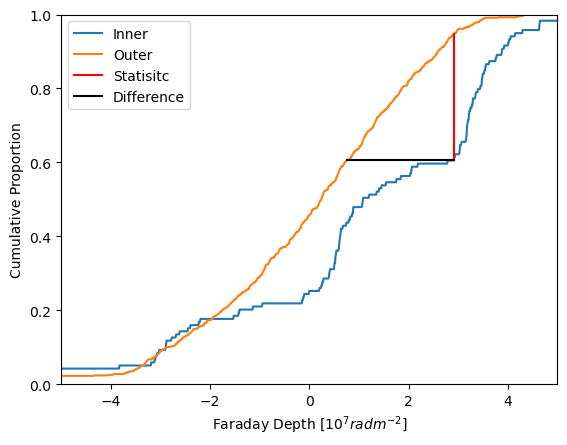

{'Name': 'G267.1-38.4+263',
 'Statistic': 0.3428488020518381,
 'p_value': 2.318648482161409e-11,
 'Statistic_x': 29.111033886656486,
 'Statistic_sgn': -1,
 'Statistic_diff': 21.553476329098928,
 'Significant': True}

In [2]:
import matplotlib.pyplot as plt

stats = kst.KStest_single(master_hvcs, p_value=1e-3, index=9, show=True)
plt.show()

stats

In [3]:
for i in range(len(master_hvcs)):
    print(calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], kst.KStest_single(master_hvcs, p_value=1e-3, index=i, show=False)['Statistic_diff'])[0].n)

Analysing HVC: G038.7-37.3-241
2.5627908299515854
Analysing HVC: G038.8-33.2-261
1.2506166058012396
Analysing HVC: G043.4-30.4-230
2.3022435957955607
Analysing HVC: G089.0-64.7-311
-2.412054865854746
Analysing HVC: G133.5-75.6-294
1.7903369992621851
Analysing HVC: G248.9+36.8+181
0.5253611952241217
Analysing HVC: G261.5-34.5+237
7.082428471099994
Analysing HVC: G262.4-26.2+143
5.011555956863386
Analysing HVC: G264.6-53.3+224
-2.1209304891602234
Analysing HVC: G267.1-38.4+263
9.414161962255921
Analysing HVC: G271.6-48.4+297
0.591631031100386
Analysing HVC: G271.7-53.1+254
-2.403763042053307
Analysing HVC: G323.0+25.6+122
0.8344595998775584


# Subtracting CDF points

In [4]:
import contextlib
from plotting import honours_plot as hplt
import numpy as np
import scipy.stats as stats
from astropy.table import Table

In [38]:
class KStest:

    def column_to_array(data):
        return data.data*1e6

    def split_RMs(RMs, centre, max_distance):
        mask = np.zeros(len(RMs), dtype=bool)
        for i in range(len(RMs)):
            rmi = RMs[i]
            mask[i] = rmi["ra_dec_obj"].separation(centre).value < max_distance

        RMs_inner = RMs[~mask]
        RMs_outer = RMs[mask]

        return RMs_inner, RMs_outer

    def morph_ring(hvc_snap, morph_type="average"):
        if morph_type == "average":
            return (hvc_snap["HVC"]["dx"] + hvc_snap["HVC"]["dy"])/2
        if morph_type == "minimum":
            return min(hvc_snap["HVC"]["dx"], hvc_snap["HVC"]["dy"])

    def make_cdfs(inner, outer, limits):
        xs = np.linspace(-limits, limits, 1000)

        inner_cdf = np.array(list(map(lambda x: KStest.edf(inner, x), xs)))
        outer_cdf = np.array(list(map(lambda x: KStest.edf(outer, x), xs)))

        return inner_cdf, outer_cdf, xs
    
    def edf(data, x):
        masked = data[data<x]
        return len(masked)/len(data)

    def KStest_single(snapshots, index = 0, show = False, dict_answer=True, p_value=0.05, morph_type="average", find_diff=True, limits=[5e7, 1e7]):
        hvc_snap = snapshots[index]
        inner_rms, outer_rms = KStest.split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], KStest.morph_ring(hvc_snap, morph_type=morph_type))
        inner = KStest.column_to_array(inner_rms["RM"]-inner_rms["interpolation_raw"])
        outer = KStest.column_to_array(outer_rms["RM"]-outer_rms["interpolation_raw"])

        print("Analysing HVC: " + hvc_snap["HVC"]["Name"])

        inner_cdf, outer_cdf, xs = KStest.make_cdfs(inner, outer, limits[0])

        if show:
            hplt.plot_cdfs(xs/limits[1], inner_cdf, xs/limits[1], outer_cdf, show=False, xlims=None)
            plt.xlabel("Faraday Depth [$10^7 rad m^{-2}$]")
            plt.xlim(-limits[0]/limits[1], limits[0]/limits[1])
            plt.ylim(0,1)
            plt.legend()

        ks_test = stats.ks_2samp(inner, outer)

        if find_diff:
            statx = ks_test.statistic_location
            statsgn = ks_test.statistic_sign

            y_inner = KStest.edf(inner, statx)

            y_outer = 0
            x_outer = 0
            for x in xs:
                y_outer = KStest.edf(outer, x)
                if y_outer >= y_inner:
                    x_outer = x
                    break

            diff = statx - x_outer

            if show:
                plt.axvline(x=statx/limits[1], ymin=y_inner if statsgn < 0 else y_inner-ks_test.statistic, ymax=y_inner+ks_test.statistic if statsgn < 0 else y_inner, c="red", label="Statisitc")

                plt.axhline(y=y_inner, xmin=(limits[0]+(x_outer if statsgn < 0 else statx))/(2*limits[0]), xmax=(limits[0]+(statx if statsgn < 0 else x_outer))/(2*limits[0]), c="black", label="Difference")

                plt.legend()

            if dict_answer:
                return {"Name":hvc_snap["HVC"]["Name"], "Statistic":ks_test.statistic, "p_value":ks_test.pvalue, "Statistic_x":ks_test.statistic_location, "Statistic_sgn":ks_test.statistic_sign, "Statistic_diff":diff, "Significant": ks_test.pvalue < p_value}

        if not dict_answer:
            return ks_test
        else:
            return {"Name":hvc_snap["HVC"]["Name"], "Statistic":ks_test.statistic, "p_value":ks_test.pvalue, "Statistic_x":ks_test.statistic_location, "Statistic_sgn":ks_test.statistic_sign, "Significant": ks_test.pvalue < p_value}
        
    def KStest_HVCs(snapshots, show=False, dict_answer=True, p_value=0.05, morph_type="average"):
        print("=== HVC KS TESTING ===")
        KSlist = []
        l = len(snapshots)
        print("Performing KS Tests")
        for i in range(len(snapshots)):
            with contextlib.redirect_stdout(None):
                KSlist.append(KStest.KStest_single(snapshots, index=i, show=show, dict_answer=dict_answer, p_value=p_value, morph_type=morph_type))
            print(str(int((i+1)/l*100))+"% \r", sep="", end="", flush=True)
        return KSlist

Analysing HVC: G267.1-38.4+263


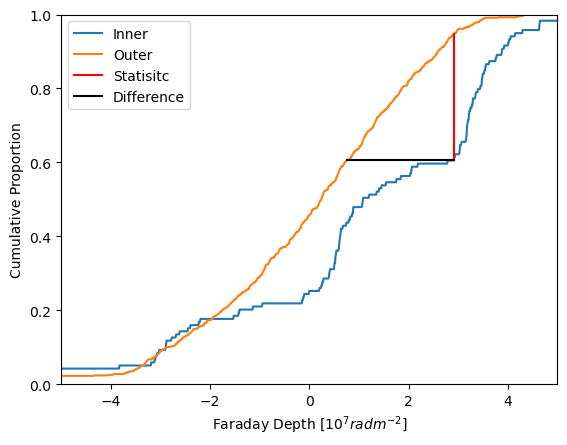

{'Name': 'G267.1-38.4+263', 'Statistic': 0.3428488020518381, 'p_value': 2.318648482161409e-11, 'Statistic_x': 29111033.886656485, 'Statistic_sgn': -1, 'Statistic_diff': 21553476.329098932, 'Significant': True}


In [39]:
from matplotlib import pyplot as plt

result = KStest.KStest_single(master_hvcs, p_value=1e-3, index=9, show=True)
plt.show()
print(result)

In [40]:
KStable_identical = KStest.KStest_HVCs(master_hvcs, p_value=1e-3)
table_stat = Table(rows=KStable_identical)
table_stat

=== HVC KS TESTING ===
Performing KS Tests


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant
str15,float64,float64,float64,int32,float64,bool
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-23129523.665567875,-1,16860466.324422114,True
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-6963302.9292322155,-1,12506166.540237254,True
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-9607423.653882606,-1,17569753.523294568,True
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-17515730.24976091,1,-12060274.794305451,False
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-5571498.219868521,-1,9893967.245596942,True
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-9225619.88896952,-1,1935541.2721916419,False
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-9242870.77545973,-1,11928300.395711444,True
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,5330447.266073939,-1,13188305.1239318,True
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,2861884.589161079,1,-6697674.970398482,True
